In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [2]:
import nltk                                              # Natural Language Toolkit: https://www.nltk.org/
from nltk.corpus import stopwords                        # "мусорные" слова (стоп-слова): предлоги, союзы, часто используемые слова ...
from nltk.stem import PorterStemmer, SnowballStemmer     # приводить разные формы одного слова к одной
from nltk.tokenize import word_tokenize                  # разделять текст на слова
from nltk import ngrams, FreqDist                        # подсчитывать частоты слов

import string                                            # string.punctuation -- символы пунктуации
from wordcloud import WordCloud                          # рисовать облако из слов

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')   # для лемматизации

[nltk_data] Downloading package stopwords to /home/raiden/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/raiden/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/raiden/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Загрузка данных
url = "https://github.com/ivtipm/ML/raw/main/datasets/IMDB%20Dataset.csv.zip"
df = pd.read_csv(url)
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [4]:
df = df.sample(5000, random_state = 42 )

In [5]:
s = 'sentiment'
r = 'review'

In [6]:
print(f"Duplicates: №{df.duplicated().sum()}")

Duplicates: №7


In [7]:
df[s].value_counts()

sentiment
positive    2519
negative    2481
Name: count, dtype: int64

In [8]:
y = df[s].apply( lambda s: 0 if s=='negative' else 1)

In [9]:
stemmer = SnowballStemmer('english', ignore_stopwords=True)
stop_words = stopwords.words('english')

In [10]:
stop_words.append('br') # html тег <br>

In [11]:
def preprocess(text, stemmer, stop_words):
    """Приводит к нижнему регистру, удаляет из текста стоп-слова, символы пунктуации, цифры"""
    words = word_tokenize(text.lower())
    return " ".join( [stemmer.stem(word) for word in words if word.isalpha() and word not in stop_words] )

In [12]:
def stem(text, stemmer):
    """Приводит к нижнему регистру, удаляет из текста стоп-слова, символы пунктуации, цифры"""
    words = word_tokenize(text.lower())
    return " ".join( [stemmer.stem(word) for word in words] )

In [13]:
X = df[r].apply(preprocess, args=(stemmer, stop_words))
X

33553    realli like summerslam due look arena curtain ...
9427     mani televis show appeal quit mani differ kind...
199      film quick get major chase scene ever increas ...
12447    jane austen would definit approv one gwyneth p...
39489    expect somewhat high went see movi thought ste...
                               ...                        
39885    one eastwood best movi separ western good when...
17566    blur childhood memori kept echo cult seri belp...
16062    love love meat market start realli promis nice...
48445    chan new york get involv attempt sabotag new a...
20382    wife thought film bbc version manhattan murder...
Name: review, Length: 5000, dtype: object

In [14]:
data = pd.DataFrame()
data[r] = X
data[s] = y
data.to_csv('imdb_preprocessed.csv')

In [15]:
data

,review,sentiment
33553,realli like summerslam due look arena curtain ...,1
9427,mani televis show appeal quit mani differ kind...,1
199,film quick get major chase scene ever increas ...,0
12447,jane austen would definit approv one gwyneth p...,1
39489,expect somewhat high went see movi thought ste...,0
...,...,...
39885,one eastwood best movi separ western good when...,1
17566,blur childhood memori kept echo cult seri belp...,0
16062,love love meat market start realli promis nice...,0
48445,chan new york get involv attempt sabotag new a...,1


In [16]:
data[s].value_counts()

sentiment
1    2519
0    2481
Name: count, dtype: int64

In [17]:
#sb.histplot(data = data, x=r, hue=s)

In [18]:
def delete_common_words(string1, string2):
    # Split the strings into words
    words1 = string1.split()
    words2 = string2.split()

    # Find the common words
    common_words = set(words1).intersection(words2)

    # Create new strings without the common words
    new_string1 = ' '.join(word for word in words1 if word not in common_words)
    new_string2 = ' '.join(word for word in words2 if word not in common_words)

    return new_string1, new_string2

In [19]:
X_positive = data[data[s]==1][r].values
X_negative = data[data[s]==0][r].values

text_positive =  ". ".join(X_positive)
text_negative =  ". ".join(X_negative)

In [20]:
text_positive_no_intersection, text_negative_no_intersection = delete_common_words(text_positive, text_negative)

In [21]:
def get_top_words(texts, N, min_df = 10):
    """
    min_df -- минимальная частота документов, где встречается слово; более редкие слова игнирируются
    texts  -- коллекция из текстов
    return: список из N самых популярных слов"""
    counter = CountVectorizer(min_df=min_df)             
    wf = counter.fit_transform( texts )
    vocabulary = list(counter.vocabulary_.items())                              # словарь
    vocabulary.sort(key = lambda x: x[1])
    vocabulary = np.array( list(map(lambda x: x[0], vocabulary) ))
    return vocabulary[ np.array(wf.sum(axis=0)).flatten().argsort()[:N] ]

print('Топ слов из положительных отзывов')
print( get_top_words(X_positive, 20) )

print()
print('Топ слов из отрицательных отзывов')
print( get_top_words(X_negative, 20) )

Топ слов из положительных отзывов
['tick' 'apt' 'approv' 'convolut' 'ultra' 'repris' 'antonio' 'resourc'
 'consum' 'breed' 'updat' 'feat' 'upset' 'fest' 'ludicr' 'luckili'
 'longest' 'compromis' 'steadi' 'leap']

Топ слов из отрицательных отзывов
['exposit' 'shed' 'inject' 'pc' 'appli' 'clunki' 'devast' 'paranoia'
 'arrog' 'pal' 'owe' 'boot' 'overlong' 'decapit' 'outing' 'legendari'
 'inferior' 'discern' 'incorrect' 'discoveri']


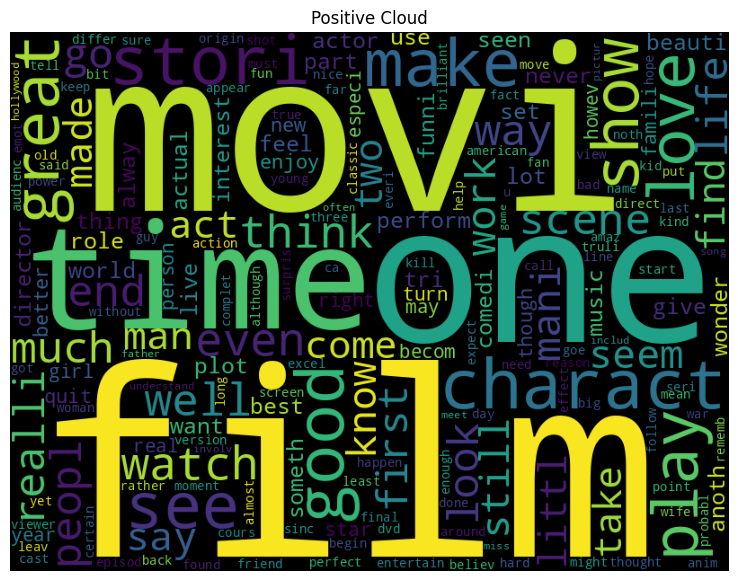

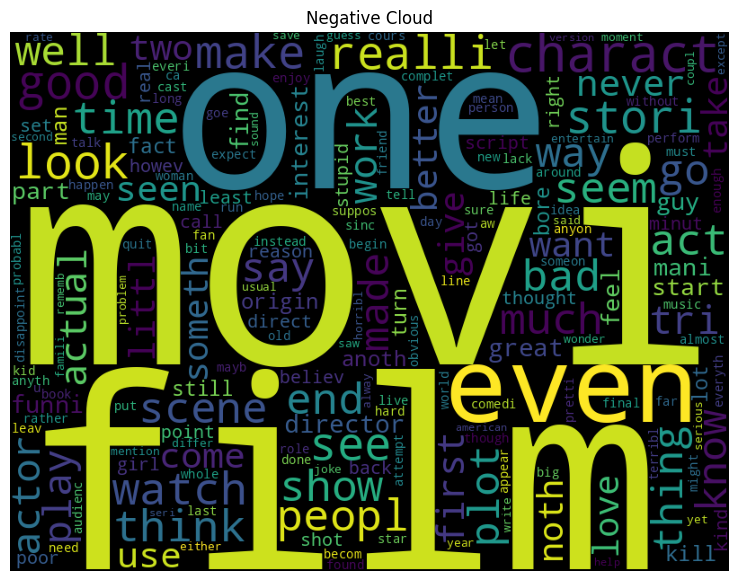

In [22]:
def plot_word_cloud(text: str, title: str):
    """Строит облако слов из текста text
    title -- заголовок для диаграммы"""
    wordcloud = WordCloud( width = 800, height = 600).generate(text)
    plt.figure(figsize = (10, 7))
    plt.title(title)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

plot_word_cloud(text_positive, 'Positive Cloud')
plot_word_cloud(text_negative, 'Negative Cloud')

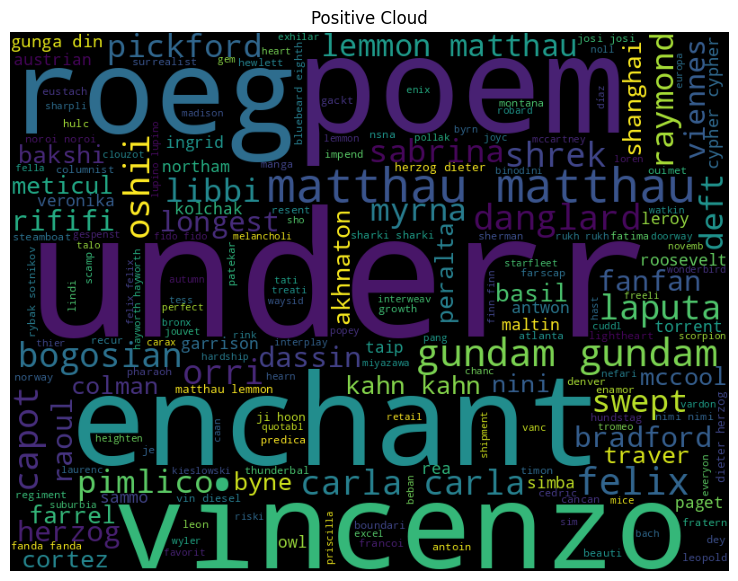

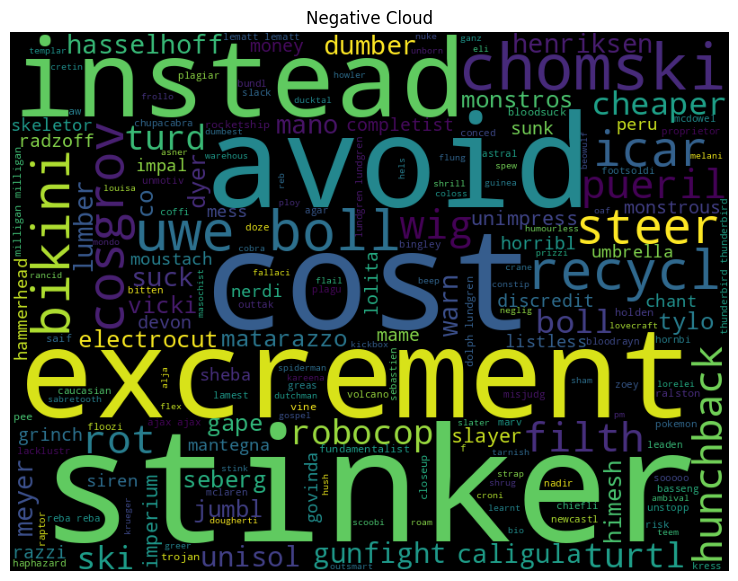

In [23]:
plot_word_cloud(text_positive_no_intersection, 'Positive Cloud')
plot_word_cloud(text_negative_no_intersection, 'Negative Cloud')

## TF-IDF

In [24]:
# Создание TF-IDF матрицы
vectorizer = TfidfVectorizer(max_features=6000, ngram_range=(1, 2), max_df=0.6, min_df=0.001)
X_tfidf = vectorizer.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.15, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

### Гиперпараметры

In [25]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold

In [26]:
from numpy import absolute, mean, std
from sklearn.model_selection import cross_val_score


def model_cross_val_score(model, X, y, scorings, silent=False):        
    for scoring in scorings:            
        cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
        scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)
        scores = absolute(scores)
        if not silent:                    
            print(f"{scoring}: mean {mean(scores):1.4f} std {std(scores):1.4f}")                          

In [27]:
def grid_search(model_class, X, y, scoring, grid, silent=False):
    first_values_dict = {k: v[0] for k, v in grid.items()}
    model = model_class(**first_values_dict)    
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)        
    search = GridSearchCV(model, grid, scoring=scoring, cv=cv, n_jobs=-1)
    results = search.fit(X, y)
    if not silent:
        print(f"Best {scoring} score: {results.best_score_:1.4f}")
        print(f"Config: {results.best_params_}")
    return results.best_params_

In [28]:
def grid_search_w_cross_val(model, X, y, validate_scorings, grid_scoring, grid):
    print(f"Searching parameters for {model.__name__} model.")                    
    params = grid_search(model, X, y, scoring=grid_scoring, grid=grid)        
    print(f"\nValidation result: ")                
    model_cross_val_score(model(**params), X, y, scorings=validate_scorings)

In [29]:
lr_grid = dict()
lr_grid['max_iter'] = np.arange(150, 350, 50)
lr_grid['solver'] = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
lr_scorings = ['f1', 'accuracy']
lr_scoring = 'f1'

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB

In [31]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import GradientBoostingClassifier

In [32]:
from numpy import arange

svc_grid = dict()
svc_grid['C'] = arange(2, 5, 1)
svc_grid['kernel'] = ['linear']
svc_scorings = ['f1', 'accuracy']
svc_scoring = 'f1'

In [33]:
nb_grid = dict()
nb_grid['alpha'] = arange(0, 1, 0.1)
nb_grid['force_alpha'] = [True, False]
nb_scorings = ['f1', 'accuracy']
nb_scoring = 'f1'

In [34]:
dt_grid = dict()
dt_grid['max_depth'] = arange(1, 12, 2)
dt_grid['min_samples_split'] = arange(1, 8, 1)
dt_grid['min_samples_leaf'] = arange(1, 8, 1)
dt_grid['criterion'] = ['gini', 'entropy', 'log_loss']

In [35]:
b_grid = dict()
b_grid['n_estimators'] = arange(1, 15, 1)
b_grid['estimator'] = [DecisionTreeClassifier(**{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 6}), MultinomialNB(alpha=0.9), LogisticRegression(**{'max_iter': 250, 'solver': 'sag'})]

In [36]:
rf_grid = dict()
rf_grid['n_estimators'] = arange(16, 40, 4)
rf_grid['max_depth'] = arange(8, 20, 3)
rf_grid['min_samples_split'] = arange(2, 16, 4)
rf_grid['min_samples_leaf'] = arange(2, 16, 4)
rf_grid['criterion'] = ['gini', 'entropy', 'log_loss']
rf_scorings = ['f1', 'accuracy', 'r2']
rf_scoring = 'f1'

In [37]:
cnb_grid = dict()
cnb_grid['alpha'] = arange(0.01, 3, 0.01)
cnb_grid['force_alpha'] = [True, False]

In [38]:
xgbc_grid = dict()
xgbc_grid['n_estimators'] = arange(50, 150, 50)
xgbc_grid['max_depth'] = arange(2, 8, 2)
xgbc_grid['max_leaves'] = arange(2, 6, 2)
xgbc_grid['grow_policy'] = [0, 1]
xgbc_grid['booster'] = ['gbtree', 'gblinear', 'dart']
xgbc_grid['learning_rate'] = arange(0.1, 1, 0.3)

In [39]:
sgb_grid=dict()
sgb_grid['subsample'] = arange(0.1, 1, 0.1) # The fraction of samples to be used for fitting the individual base learners. If smaller than 1.0 this results in Stochastic Gradient Boosting. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
sgb_grid['n_estimators'] = arange(100, 500, 50)
sgb_grid['learning_rate'] = arange(0.1, 3, 0.3)
sgb_grid['loss'] = ['log_loss', 'deviance', 'exponential']

In [40]:
# Модели
models = [
    # { 
    #     'model': LogisticRegression,
    #     'name': 'Logistic Regression',
    #     'grid_scoring': lr_scoring,
    #     'grid': lr_grid,
    #     'val_scoring': lr_scorings,
    # },
    # { 
    #     'model': MultinomialNB,
    #     'name': 'Naive Bayes',
    #     'grid_scoring': nb_scoring,
    #     'grid': nb_grid,
    #     'val_scoring': nb_scorings,
    # },    
    # { 
    #     'model': SVC,
    #     'name': 'Support Vector Machine',
    #     'grid_scoring': svc_scoring,
    #     'grid': svc_grid,
    #     'val_scoring': svc_scorings,
    # },           
    # { 
    #     'model': DecisionTreeClassifier,
    #     'name': 'Decision Tree Classifier',
    #     'grid_scoring': svc_scoring,
    #     'grid': dt_grid,
    #     'val_scoring': svc_scorings,
    # },           
    # { 
    #     'model': RandomForestClassifier,
    #     'name': 'RandomForestClassifier',
    #     'grid_scoring': rf_scoring,
    #     'grid': rf_grid,
    #     'val_scoring': rf_scorings,
    # },     
    # { 
    #     'model': CategoricalNB,
    #     'name': 'CategoricalNB',
    #     'grid_scoring': rf_scoring,
    #     'grid': cnb_grid,
    #     'val_scoring': rf_scorings,
    # },        
    # { 
    #     'model': XGBClassifier,
    #     'name': 'XGBClassifier',
    #     'grid_scoring': rf_scoring,
    #     'grid': xgbc_grid,
    #     'val_scoring': rf_scorings,
    # },        
    # { 
    #     'model': GradientBoostingClassifier,
    #     'name': 'GradientBoostingClassifier',
    #     'grid_scoring': rf_scoring,
    #     'grid': sgb_grid,
    #     'val_scoring': rf_scorings,
    # },           
]

In [41]:
# Поиск параметров
for model in models:  
    grid_search_w_cross_val(model['model'], X_train, y_train, model['val_scoring'], model['grid_scoring'], model['grid'])

### Результат

In [42]:
# Модели
cmodels = [
    { 
        'model': LogisticRegression,
        'name': 'Logistic Regression',
        'config': {'max_iter': 250, 'solver': 'sag'}   # {'max_iter': 150, 'solver': 'liblinear'} # - на 5к отзывах
    },
    { 
        'model': SVC,
        'name': 'Support Vector Machine',
        'config': {'C': 2.0, 'kernel': 'linear'}
    },           
    { 
        'model': MultinomialNB,
        'name': 'Naive Bayes',
        'config': {'alpha': 0.9}        
    },
    { 
        'model': DecisionTreeClassifier,
        'name': 'Decision Tree Classifier',
        'config': {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 6}
    },               
    { 
        'model': BaggingClassifier,
        'name': 'BaggingClassifier',
        'config': {'estimator': LogisticRegression(max_iter=250, solver='sag'), 'n_estimators': 6}
    },       
    { 
        'model': BaggingClassifier,
        'name': 'BaggingClassifier',
        'config': {'estimator': LogisticRegression(max_iter=350, solver='sag'), 'n_estimators': 6}
    },           
    {
        'model': RandomForestClassifier,
        'name': 'RandomForestClassifier',
        'config': {'criterion': 'log_loss', 'max_depth': 11, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 19}
        
    },       
    {
        'model': RandomForestClassifier,
        'name': 'RandomForestClassifier',
        'config': {'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 60}
        
    },      
    { 
        'model': GaussianNB,
        'name': 'GaussianNB',
        'config': {}
    },
    { 
        'model': CategoricalNB,
        'name': 'CategoricalNB',
        'config': {'alpha': 0.01, 'force_alpha': True}
    },
    { 
        'model': XGBClassifier,
        'name': 'XGBClassifier',
        'config': {'n_estimators': 250}
    },        
    { 
        'model': GradientBoostingClassifier,
        'name': 'GradientBoostingClassifier',
        'config': {'subsample': 0.2, 'n_estimators': 200}
    },             
]

In [43]:
# Обучение и оценка моделей
for item in cmodels:       
    m = item['model']
    model_name = item['name']
    config = item['config']
    model = m(**config)
    if model_name in ['GaussianNB', 'CategoricalNB']:
        model.fit(np.asarray(X_train.todense()), y_train)
        y_pred = model.predict(X_test.toarray())
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}\n")    

Model: Logistic Regression
Accuracy: 0.8440, Precision: 0.8466, Recall: 0.8440, F1-Score: 0.8438

Model: Support Vector Machine
Accuracy: 0.8213, Precision: 0.8231, Recall: 0.8213, F1-Score: 0.8212

Model: Naive Bayes
Accuracy: 0.8480, Precision: 0.8491, Recall: 0.8480, F1-Score: 0.8480

Model: Decision Tree Classifier
Accuracy: 0.7107, Precision: 0.7249, Recall: 0.7107, F1-Score: 0.7069

Model: BaggingClassifier
Accuracy: 0.8333, Precision: 0.8381, Recall: 0.8333, F1-Score: 0.8329

Model: BaggingClassifier
Accuracy: 0.8427, Precision: 0.8448, Recall: 0.8427, F1-Score: 0.8425

Model: RandomForestClassifier
Accuracy: 0.8013, Precision: 0.8112, Recall: 0.8013, F1-Score: 0.8001

Model: RandomForestClassifier
Accuracy: 0.8027, Precision: 0.8095, Recall: 0.8027, F1-Score: 0.8019

Model: GaussianNB
Accuracy: 0.7507, Precision: 0.7511, Recall: 0.7507, F1-Score: 0.7507



/home/raiden/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: CategoricalNB
Accuracy: 0.4920, Precision: 0.2421, Recall: 0.4920, F1-Score: 0.3245

Model: XGBClassifier
Accuracy: 0.8173, Precision: 0.8189, Recall: 0.8173, F1-Score: 0.8172

Model: GradientBoostingClassifier
Accuracy: 0.8093, Precision: 0.8120, Recall: 0.8093, F1-Score: 0.8091



## NN

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary 
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report

In [45]:
# Создание модели нейронной сети
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)                
        self.fc5 = nn.Linear(hidden_size, output_size)        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))             
        return x

In [46]:
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
#X_val_tensor = torch.tensor(X_val.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values)
y_test_tensor = torch.tensor(y_test.values)
#y_val_tensor = torch.tensor(y_val.values)

In [47]:
class TFIDFDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y

# Step 3: Initialize dataset classes
train_dataset = TFIDFDataset(X_train_tensor, y_train_tensor)
test_dataset = TFIDFDataset(X_test_tensor, y_test_tensor)
#val_dataset = TFIDFDataset(X_val_tensor, y_val_tensor)

In [48]:
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
#val_laoder = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [49]:
# Создание модели и оптимизатора
input_size = X_train.shape[1]
hidden_size = 32
output_size = 8
model = Net(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Обучение модели
num_epochs = 300
for epoch in range(num_epochs):
    for inputs, labels in train_loader:        
        #labels = labels.unsqueeze(1)        
        optimizer.zero_grad()
        outputs = model(inputs)        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/300], Loss: 0.7073
Epoch [20/300], Loss: 0.1390
Epoch [30/300], Loss: 0.0004
Epoch [40/300], Loss: 0.0002
Epoch [50/300], Loss: 0.0001
Epoch [60/300], Loss: 0.0000
Epoch [70/300], Loss: 0.0000
Epoch [80/300], Loss: 0.0000
Epoch [90/300], Loss: 0.0000
Epoch [100/300], Loss: 0.0000
Epoch [110/300], Loss: 0.0000
Epoch [120/300], Loss: 0.0000
Epoch [130/300], Loss: 0.0000
Epoch [140/300], Loss: 0.0000
Epoch [150/300], Loss: 0.0000
Epoch [160/300], Loss: 0.0000
Epoch [170/300], Loss: 0.0000
Epoch [180/300], Loss: 0.0000
Epoch [190/300], Loss: 0.0000
Epoch [200/300], Loss: 0.0000
Epoch [210/300], Loss: 0.0000
Epoch [220/300], Loss: 0.0000
Epoch [230/300], Loss: 0.0000
Epoch [240/300], Loss: 0.0000
Epoch [250/300], Loss: 0.0000
Epoch [260/300], Loss: 0.0000
Epoch [270/300], Loss: 0.0000
Epoch [280/300], Loss: 0.0000
Epoch [290/300], Loss: 0.0000
Epoch [300/300], Loss: 0.0000


In [50]:
from sklearn.metrics import classification_report

total_correct = 0
total_samples = 0
true_labels = []
predicted_labels = []

model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:        
        outputs = model(inputs)        
        _, predicted = torch.max(outputs, dim=1)        
        total_correct += (predicted == labels).sum().item()                
        total_samples += labels.size(0)
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

accuracy = total_correct / total_samples
print("Accuracy: {:.2f}%".format(accuracy * 100))
classification_rep = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(classification_rep)

Accuracy: 81.73%
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       381
           1       0.79      0.85      0.82       369

    accuracy                           0.82       750
   macro avg       0.82      0.82      0.82       750
weighted avg       0.82      0.82      0.82       750



## word2vec

In [51]:
import gensim.downloader
from gensim.models import Word2Vec, KeyedVectors
from nltk.tokenize import word_tokenize

In [52]:
def preprocess_text2list(text, vectors, stop_words):
    """ очищает и стеммит текст
    return: список слов """
    # список из слов потом можно использовать, чтобы сделать из него список векторов    
    words = word_tokenize(text.lower())
    return [ stemmer.stem(word) for word in words if word.isalpha() and (word not in stop_words) and (word in vectors) ]   


vectors = gensim.downloader.load('glove-twitter-25')
data['review_lst'] = data[r].apply(preprocess_text2list, args=(vectors, stop_words))
data['tokenized_review'] = [[vectors[word] for word in text if word in vectors] for text in data['review_lst'].values]

In [53]:
def average_vec( vecs ):
    """ Считает средний вектор по списку 
    vecs -- список из numpy массивов"""
    
    aver = np.zeros( len(vecs[0]) )
    for i in range(len(vecs)):
        aver+= vecs[i]
    return aver/len(vecs)

X_vec = [average_vec(rev_vecs) for rev_vecs in data['tokenized_review'].values]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

### Результат

In [55]:
# Модели
w2v_models = [
    { 
        'model': LogisticRegression,
        'name': 'Logistic Regression',
        'config': {'max_iter': 250, 'solver': 'sag'}   # {'max_iter': 150, 'solver': 'liblinear'} # - на 5к отзывах
    },
    { 
        'model': SVC,
        'name': 'Support Vector Machine',
        'config': {'C': 2.0, 'kernel': 'linear'}
    },           
    { 
        'model': GaussianNB,
        'name': 'GaussianNB',
        'config': {}
    }     
]

In [56]:
# Обучение и оценка моделей
for item in w2v_models:       
    m = item['model']
    model_name = item['name']
    config = item['config']
    model = m(**config)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}\n")    

Model: Logistic Regression
Accuracy: 0.7090, Precision: 0.7091, Recall: 0.7090, F1-Score: 0.7090

Model: Support Vector Machine
Accuracy: 0.7130, Precision: 0.7131, Recall: 0.7130, F1-Score: 0.7130

Model: GaussianNB
Accuracy: 0.6510, Precision: 0.6512, Recall: 0.6510, F1-Score: 0.6506



## Выводы 

#### TF-IDF

Преимущества:

* Простота реализации и интерпретации.
* Учитывает важность слова в документе, основываясь на его частоте в документе и обратной частоте 
* Хорошо работает для задач классификации текстов, анализа тональности и информационного извлечения.

Недостатки:

* Не учитывает семантическую связь между словами, поэтому может упустить важные смысловые аспекты текста.
* Ограниченный размер словаря может привести к потере информации.
* Не учитывает порядок слов в тексте, что может быть важным для некоторых задач.

#### Word2Vec

Преимущества:

* Учитывает семантическую связь между словами, что позволяет захватить смысловые аспекты текста.
* Можно выполнять поиск ближайших слов и арифметические операции над векторами.
* Работает лучше для слов, которые не встречались в обучающем наборе, благодаря контекстному обучению.

Недостатки:

* Более сложная реализация и обучение по сравнению с TF-IDF.
* Могут возникать проблемы с редкими словами или словами, которые не встречаются в обучающем наборе.
* Не учитывает порядок предложений или документов.

Существуют разные алгоритмы:
* FastText
* Glove
* Google News Vectors